In [1]:
# Challenger Space Shuttle Disaster
import numpy as np
import pymc3 as pm
% matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import theano.tensor as tt

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`


C:\Users\o00408152\AppData\Local\Programs\Python\Python36\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


C:\Users\o00408152\AppData\Local\Programs\Python\Python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
x = stats.norm.rvs(loc=15,scale=5, size=25)
x

array([20.40483544, 14.30338684, 16.52944023, 20.86063299, 13.80919735,
        5.39083028,  9.02014065,  9.49838414, 14.91785929, 19.21218867,
       14.56711443, 17.01535807, 15.59207664, 13.31541873,  9.37140626,
       16.5584653 , 15.19701104, 21.54648323, 17.39101552, 17.43091004,
       10.66905863, 15.64871781, 22.12725551, 14.09564859, 21.68593494])

In [22]:
#k = the logistic growth rate or steepness of the curve
# x0 mid point
x_0 = 15
k = 1
y = 1 - 1.0 / (1.0 + np.exp(- k * (x - x_0)))
y


array([4.47468125e-03, 6.67436439e-01, 1.78075601e-01, 2.84134322e-03,
       7.66884587e-01, 9.99932894e-01, 9.97477199e-01, 9.95936407e-01,
       5.20523639e-01, 1.45976616e-02, 6.06562505e-01, 1.17599830e-01,
       3.56158519e-01, 8.43510215e-01, 9.96419243e-01, 1.73866977e-01,
       4.50905928e-01, 1.43309712e-03, 8.38603786e-02, 8.08458164e-02,
       9.87015653e-01, 3.43278534e-01, 8.02275812e-04, 7.11842898e-01,
       1.24679066e-03])

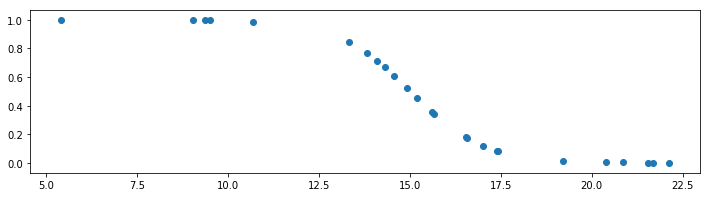

In [23]:
figsize(12, 3)
plt.scatter(x,y)

In [38]:
obs = stats.bernoulli.rvs(y)
obs


array([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0])

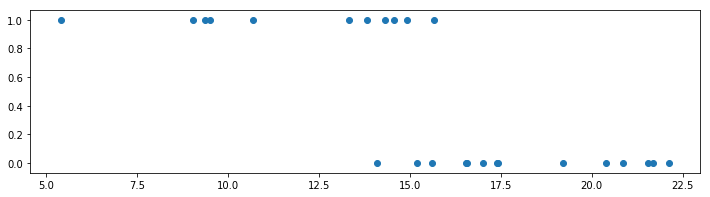

In [39]:
plt.scatter(x,obs)

In [40]:
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0 / (1. + tt.exp(beta * x + alpha)))


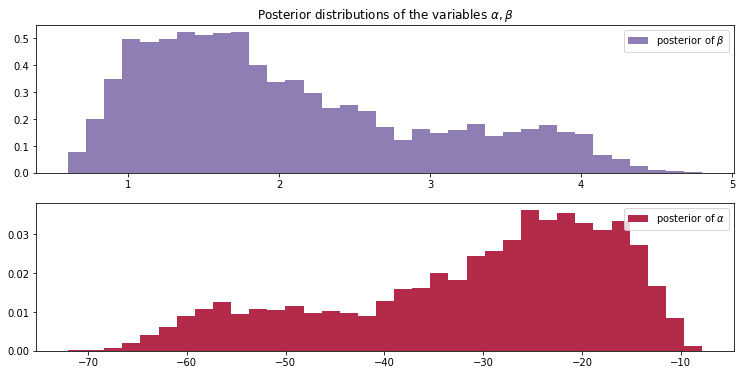

In [ ]:
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=obs)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]


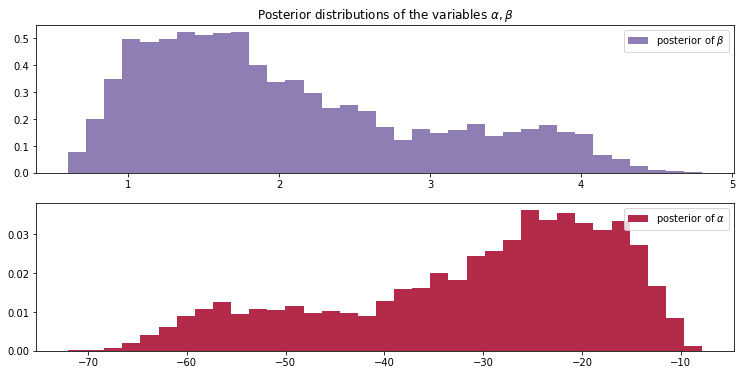

In [42]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend()


In [43]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

In [44]:
t = np.linspace(x.min() - 5, x.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)


Text(0.5,0,'temperature')

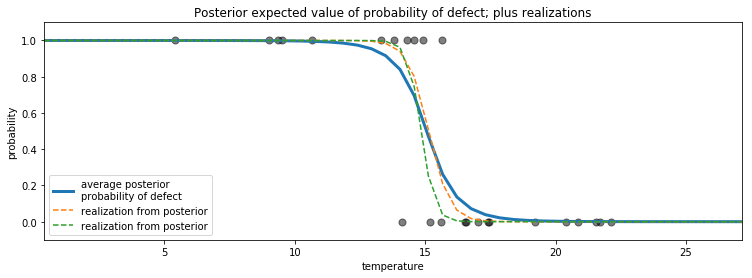

In [50]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-10, :], ls="--", label="realization from posterior")
plt.scatter(x, obs, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature")


Text(0.5,1,'Posterior probability estimates given temp. $t$')

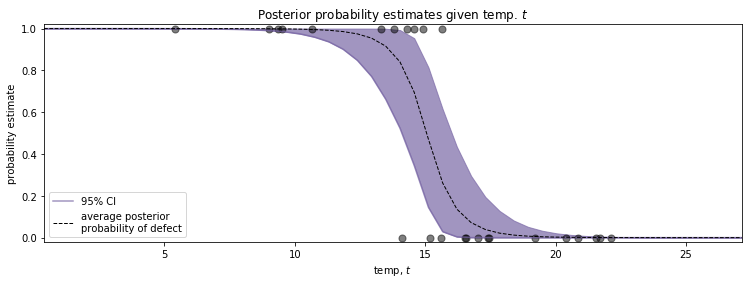

In [51]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(x, obs, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$")


Text(0.5,0,'probability of defect occurring in O-ring')

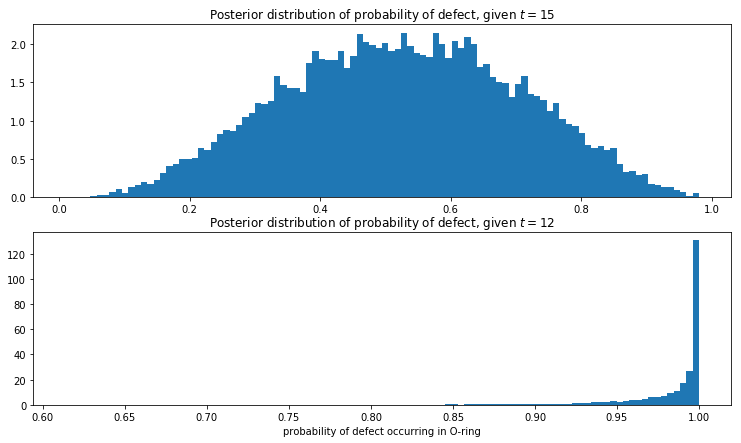

In [67]:

figsize(12.5, 7)

prob_15 = logistic(15, beta_samples, alpha_samples)
prob_12 = logistic(12, beta_samples, alpha_samples)

plt.xlim(0, 1)
plt.subplot(211)
plt.title("Posterior distribution of probability of defect, given $t = 15$")
plt.hist(prob_15, bins=100, normed=True, histtype='stepfilled')
plt.subplot(212)
plt.hist(prob_12, bins=100, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 12$")
plt.xlabel("probability of defect occurring in O-ring")
